In [1]:
import requests
import pandas as pd

url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/'
docs_url = url_prefix + 'search_evaluation/documents-with-ids.json'
documents = requests.get(docs_url).json()

ground_truth_url = url_prefix + 'search_evaluation/ground-truth-data.csv'
df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [2]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef'}

In [3]:
ground_truth[8]

{'question': 'Where can I find the office hours sessions?',
 'course': 'machine-learning-zoomcamp',
 'document': '39fda9f0'}

In [4]:
doc_idx = {d['id']: d for d in documents}

In [5]:
doc_idx['c02e79ef']['text']

"The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel."

## Index data
We'll generate embeddings using the sentence transformers library, if you don't have it, install it with pip:

pip install sentence-transformers
This is a different way of turning sentences into vectors

In [6]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from tqdm.auto import tqdm

vectors = []

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    vector = model.encode(question + ' ' + text)
    vectors.append(vector)

  0%|                                                                                                          | 0/948 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:56<00:00, 16.71it/s]


In [8]:
import numpy as np

vectors = np.array(vectors)

In [9]:
from minsearch import VectorSearch

vindex = VectorSearch(keyword_fields=['course'])
vindex.fit(vectors, documents)

## Retrieval

In [10]:
def minsearch_vector_search(vector, course):
    return vindex.search(
        vector,
        filter_dict={'course': course},
        num_results=5
    )

def question_text_vector(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return minsearch_vector_search(v_q, course)

In [11]:
question_text_vector(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'section': 'General course-related questions',
  'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'id': '5170565b'},
 {'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'section': 'General course-related questions',
  'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'id': '39fda9f0'},
 {'text': "Problem description\nThe accuracy and the loss are both still the same or nearly the same while training.\nSol

## The RAG Flow

In [12]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [65]:
from ratelimit import limits, sleep_and_retry
from google import genai

gg_client = genai.Client()

@sleep_and_retry
@limits(calls=8, period=60)
def llm(prompt, model="gemini-2.5-flash"):
    response = gg_client.models.generate_content(
    model=model,
    contents=prompt
    )

    return response.text

In [14]:
def rag(query: dict, model="gemini-2.5-flash") -> str:
    search_results = question_text_vector(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt)

    return answer

In [15]:
#Test on ground truth set
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [16]:
rag(ground_truth[10])

/home/codespace/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


"Yes, everything is recorded, so you won't miss anything. This includes the pre-recorded course videos and the live office hours sessions."

In [17]:
doc_idx['5170565b']

{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'section': 'General course-related questions',
 'question': 'What if I miss a session?',
 'course': 'machine-learning-zoomcamp',
 'id': '5170565b'}

## Cosine Similarity Metric

In [18]:
answer_org = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'
answer_llm = "Yes, everything is recorded, so you won't miss anything. This includes the pre-recorded course videos and the live office hours sessions."

v_org = model.encode(answer_org)
v_llm = model.encode(answer_llm)

v_org.dot(v_llm)

/home/codespace/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


np.float32(0.64593995)

In [19]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [20]:
# @sleep_and_retry
# @limits(calls=8, period=60)
# def rag_limited(rec):
#     return rag(rec)

# answers = {}

# for i, rec in enumerate(tqdm(ground_truth)):
#     if i in answers:
#         continue
    
#     answer_llm = rag_limited(rec)
#     doc_id = rec['document']
#     original_doc = doc_idx[doc_id]
#     answer_ori = original_doc['text']

#     answers[i] = {
#         'answer_llm': answer_llm,
#         'answer_ori': answer_ori,
#         'document': doc_id,
#         'question': rec['question'],
#         'course': rec['course']
#     }

In [21]:
answers = {}

In [22]:
import pandas as pd
df_gpt4o = pd.read_csv('data/results-gpt4o.csv')
df_gpt4o.head()

,answer_llm,answer_orig,document,question,course
0,The CONTEXT provided does not give specific in...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up for the Machine Learning Zoomc...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"No, the provided context does not include any ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


## Cosine Similarity

### GPT-4o

In [23]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

In [24]:
record = results_gpt4o[0]

In [25]:
def compute_similarity(record):
    answer_org = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_org = model.encode(answer_org)
    v_llm = model.encode(answer_llm)
    
    return v_org.dot(v_llm)

In [26]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|                                                                                                         | 0/1830 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [02:57<00:00, 10.31it/s]


In [27]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153425
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

In [28]:
import seaborn as sns

### GPT-3.5

In [29]:
df_gpt35 = pd.read_csv('data/results-gpt35.csv')
df_gpt35.head()

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by going to the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,"I am sorry, but there is no direct link provid...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"No, the course does not have a GitHub reposito...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,Based on the information provided in the FAQ d...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [30]:
results_gpt35 = df_gpt35.to_dict(orient='records')

In [31]:
similarity35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity35.append(sim)

  0%|                                                                                                         | 0/1830 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [02:17<00:00, 13.31it/s]


In [32]:
df_gpt35['cosine'] = similarity35
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

In [33]:
import matplotlib.pyplot as plt

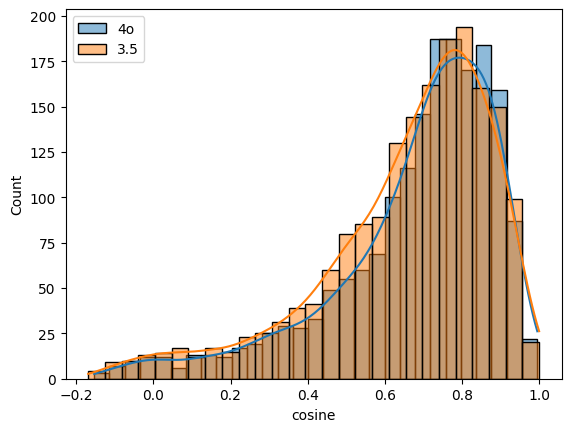

In [34]:
sns.histplot(df_gpt4o['cosine'],kde=True, label='4o')
sns.histplot(df_gpt35['cosine'],kde=True, label='3.5')

plt.legend()

### GPT-4omini

In [35]:
df_gpt4omini = pd.read_csv('data/results-gpt4o-mini.csv')
df_gpt4omini.head()

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by visiting the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up using the link provided in the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,The context does not provide any specific info...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [36]:
results_gpt4omini = df_gpt4omini.to_dict(orient='records')

In [37]:
similarity4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity4o_mini.append(sim)

  0%|                                                                                                         | 0/1830 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [02:31<00:00, 12.09it/s]


In [38]:
df_gpt4omini['cosine'] = similarity4o_mini
df_gpt4omini['cosine'].describe()

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

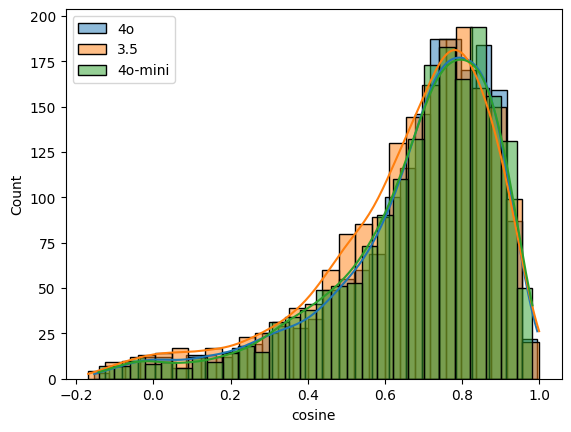

In [39]:
sns.histplot(df_gpt4o['cosine'],kde=True, label='4o')
sns.histplot(df_gpt35['cosine'],kde=True, label='3.5')
sns.histplot(df_gpt4omini['cosine'],kde=True, label='4o-mini')

plt.legend()

## LLM-as-a-judge

In [40]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [41]:
df_samples = df_gpt4omini.sample(n=150, random_state=1)

In [42]:
samples = df_samples.to_dict(orient='records')

In [46]:
record = samples[0]

In [47]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_

In [48]:
answer = llm(prompt)

In [49]:
import json

In [51]:
json.loads(answer)

{'Relevance': 'RELEVANT',
 'Explanation': 'The generated answer directly provides the syntax example for `precision_recall_fscore_support` which is extracted verbatim from the original answer. It fully addresses the generated question using the provided context.'}

In [52]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt)
    evaluations.append(evaluation)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [14:54<00:00,  5.96s/it]


In [53]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [59]:
df_evaluations = pd.DataFrame(json_evaluations)
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           132
NON_RELEVANT        16
PARTLY_RELEVANT      2
Name: count, dtype: int64

In [61]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
4,NON_RELEVANT,The original answer clearly states the error i...
11,NON_RELEVANT,The original answer addresses a `NotSupportedE...
27,NON_RELEVANT,The generated answer incorrectly states that '...
44,NON_RELEVANT,"The original answer is extremely vague ('Yes, ..."
45,NON_RELEVANT,The generated answer incorrectly states that t...
49,NON_RELEVANT,The generated answer incorrectly states there ...
52,NON_RELEVANT,The generated answer recommends a data splitti...
58,NON_RELEVANT,"The generated answer states, 'However, it does..."
62,NON_RELEVANT,"The generated answer starts with 'No,' which d..."
67,NON_RELEVANT,The original answer 'TODO' is a placeholder or...


In [63]:
samples[41]

{'answer_llm': 'To set up a Conda environment on your computer, you need to run the command `conda create -n ml-zoomcamp python=3.9` (or specify another version such as 3.8 or 3.10). This command is only needed the first time to create the environment. After the environment is created, you can activate it by running `conda activate ml-zoomcamp` whenever you want to use it. Additionally, you can export your environment to a YAML file for later reproduction using `conda env export > environment.yml`, and recreate it with `conda env create -f environment.yml`. If you are on Windows and just installed Anaconda, you should use Anaconda’s terminal called "Anaconda Prompt." If you do not have Anaconda or Miniconda installed, you will need to install one of them first.',
 'answer_orig': 'Yes. Whoever corrects the homework will only be able to access the link if the repository is public.\n(added by Tano Bugelli)\nHow to install Conda environment in my local machine?\nWhich ide is recommended fo

In [66]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt)
    evaluations_2.append(evaluation)

 47%|█████████████████████████████████████████████▎                                                   | 70/150 [08:11<09:21,  7.02s/it]


ServerError: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}

In [ ]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [ ]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)
df_evaluations_2.Relevance.value_counts()

In [ ]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']